In [47]:
# Last mod: FA 2023 Feb 17

# Predicting ages from spectroscopic abundances with XGBoost 

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [3]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


There is also a column informing about the evolutionary state (RC / RGB):

In [4]:
mig['evstate']

0       1
1       1
2       1
3       1
4       1
       ..
3310    2
3311    1
3312    1
3313    1
3314    2
Name: evstate, Length: 3315, dtype: int32

We'll also have a look at the APOGEE DR17 abundance flags:

In [5]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

RV_FLAG
0     3314
32       1
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      3314
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      3312
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      3272
256      37
288       6
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    3315
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      3311
256       3
1         1
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    3315
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0    3315
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    3315
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      3270
258      30
0         8
3         4
259       3
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      3314
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      3313
1         1
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    3315
Name: CA_FE_FLAG, dtype: int64

TI_FE_FLAG
0    3315
Name: TI_FE_FLAG, dtype: int64

TIII_FE_FLAG
0      3307
257       4
256       3
1         1
Name: TIII_FE_FLAG, dtype: int64


## Data selection criteria

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [6]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TIII_FE_FLAG'] == 0)& \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)]

In [7]:
print(len(mig), "suffice the FLAG conditions")

3250 suffice the FLAG conditions


(array([  3.,   7.,  29., 149., 399., 653., 925., 741., 277.,  59.]),
 array([-0.94691998, -0.80627298, -0.66562599, -0.524979  , -0.384332  ,
        -0.24368499, -0.103038  ,  0.037609  ,  0.17825601,  0.318903  ,
         0.45954999]),
 <BarContainer object of 10 artists>)

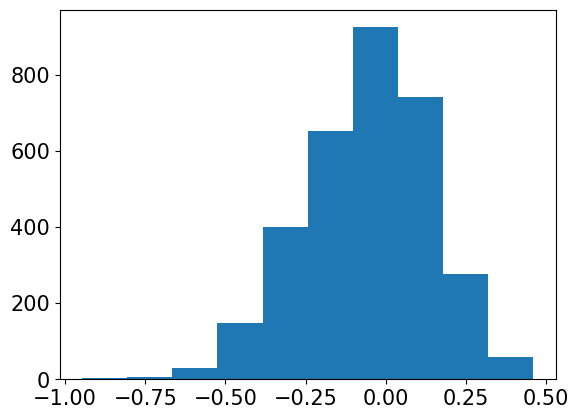

In [8]:
plt.hist(mig["FE_H"])

## Some plots (overplotting the training set over the full APOGEE DR17 data):

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [56]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


Define the same selection as for the training set:

In [58]:
selection = (big['TEFF'] < 5200) & (big['TEFF'] > 4400) & \
            (big['LOGG'] < 3.4)  & (big['LOGG'] > 2.2)  & \
            (big['FE_H'] > -1)   & (big['SNREV'] >= 50) & \
            (big['TEFF_ERR'] < 150) & (big['RV_FLAG'] == 0)  & \
            (big['C_FE_FLAG'] == 0) & (big['N_FE_FLAG'] == 0) & \
            (big['CI_FE_FLAG'] == 0)& (big['O_FE_FLAG'] == 0)  & \
            (big['TI_FE_FLAG'] == 0)& (big['CA_FE_FLAG'] == 0)  & \
            (big['AL_FE_FLAG'] == 0)& (big['CO_FE_FLAG'] == 0)  & \
            (big['NI_FE_FLAG'] == 0)& (big['MN_FE_FLAG'] == 0)

print(np.sum(selection), "stars with good quality")

194344 stars with good quality


### $T_{\rm eff}-\log g$ diagram

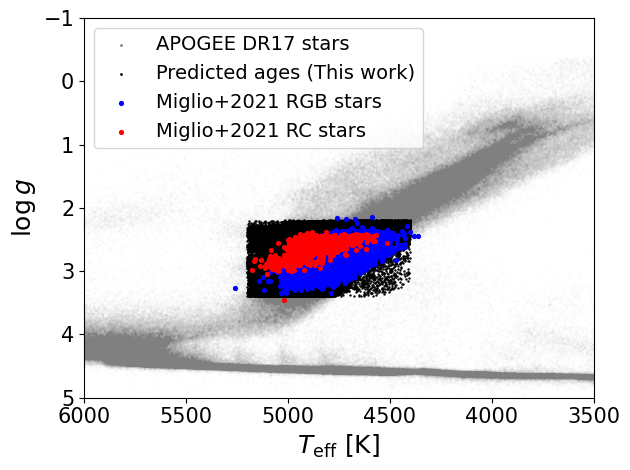

In [25]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.01, s=1, label="_nolabel")
plt.scatter(-999, -999, c="grey", alpha=1, s=1, label="APOGEE DR17 stars")
plt.scatter(big['TEFF'][selection], big['LOGG'][selection], c="k", s=.5, label="_nolabel")
plt.scatter(-999, -999, c="k", alpha=1, s=1, label="Predicted ages (This work)")
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.axis([6000, 3500, 5, -1.])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()
plt.savefig("../im/kiel_diagram.png", dpi=300)

### Age uncertainties of the Miglio+2021 sample

Median rel. age uncertainty for RGB: 0.22727275
Median rel. age uncertainty for RC: 0.097561


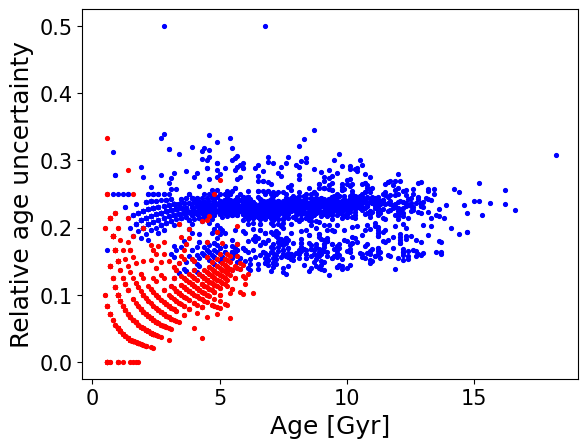

In [26]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png", dpi=300)

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

## Galactic distribution

In [27]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Feb2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_feb2023'])

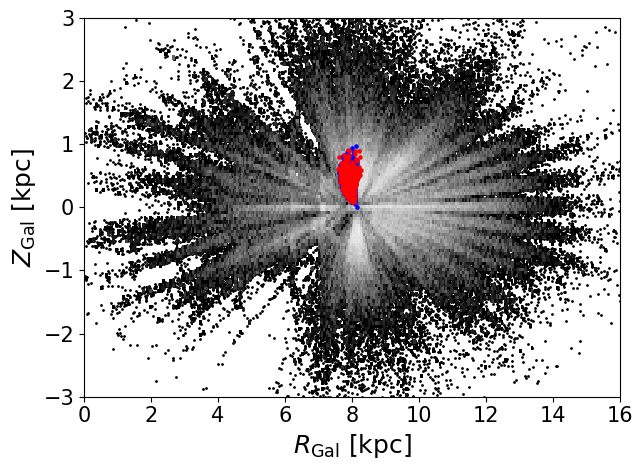

In [28]:
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=1, label="APOGEE DR17")
Ht,X1,X2 = np.histogram2d(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], 
                          bins=[320,120], range=[[0, 16], [-3, 3]])
Ht[Ht<2] = np.nan
image = plt.pcolor(0.5*(X1[:-1]+X1[1:]), 0.5*(X2[:-1]+X2[1:]), Ht.T, cmap="Greys_r", 
                   label=r"APOGEE DR17 giants", norm=colors.LogNorm())
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all.png", dpi=300)

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [29]:
filtered_df = mig[['Age',   'TEFF',  'LOGG', 
                   'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
                   'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
                   'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
                   'CO_FE', 'NI_FE' ]].copy() # excluding: ['FE_H', 'CE_FE']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [30]:
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583
5,10.0,4684.613281,2.848780,0.104613,0.138510,0.141330,0.223403,0.108262,0.297463,0.224611,0.378678,0.103955,0.120173,-0.176968,-0.106488,0.13391,0.124313


In [31]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Train XGBoost

Test if the algorithm works - this should be really fast:

In [32]:
filename = './models/test_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 10, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.499214
Score: 0.8057988132789198


### Run gridsearch to optimise the hyperparameters:
Running the following cell takes a while (~30 min on an 8-core computer with 16GB RAM)... so it's not recommended to run it unless you really need it.

### Run the algorithm with optised hyperparameters:

In [33]:
filename = './models/default_model.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 1000, learning_rate = 0.01,
                             max_depth = 5, min_child_weight = 4, 
                             subsample = 0.6, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

RMSE :  1.365111
Score: 0.8389873218935928


### Separate models for RGB and RC?

In [34]:
# Define a function that does the magic:

def xgboost(filtered_df):
    # Split dataframe into input and output columns
    y = filtered_df['Age']
    X = filtered_df.drop(columns = 'Age')
    
    # Splitting into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                          test_size = 0.2, random_state = 123)
      
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 500, learning_rate = 0.02,
                             max_depth = 5, min_child_weight = 4, 
                             subsample = 0.7, seed = 123)    
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    return model, test_y, pred

In [35]:
# Consider fitting RGBs and RCs separately:
rgbs = filtered_df[mig["evstate"]==1]
rcs  = filtered_df[mig["evstate"]==2]
model_rgb, test_rgb, pred_rgb = xgboost(rgbs)
model_rc,  test_rc,  pred_rc  = xgboost(rcs)
# Save these models:
pickle.dump(model_rgb, open('./models/rgb_model.pkl', 'wb'))
pickle.dump(model_rc,  open('./models/rc_model.pkl',  'wb'))

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


# Plots

In [36]:
def running_median(X, Y, nbins=10):
    bins = np.linspace(X.min(),X.max(), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.quantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.quantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.quantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    return bins[1:] - delta/2, med, q16, q84

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=3)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)

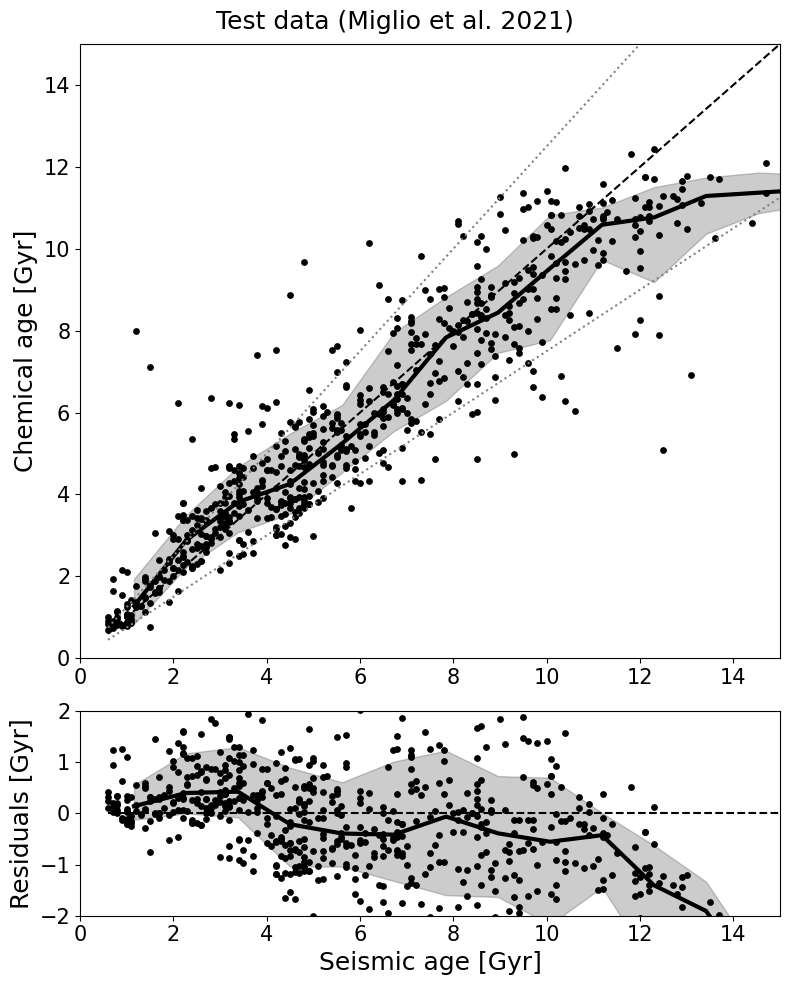

In [48]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

plot_rgb_rc = False

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Default model")
overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a0.scatter(test_rgb, pred_rgb, c="b", s=10, label="RGB model")
    overplot_trend(test_rgb, pred_rgb, alpha=0.2, color="b", bins=10)
    a0.scatter(test_rc,  pred_rc, c="r", s=10, label="RC model")
    overplot_trend(test_rc,  pred_rc, alpha=0.2, color="r", bins=10)
xx = np.linspace(np.min(test_y), np.max(test_y), 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Chemical age [Gyr]", fontsize=18)
#a0.legend(loc="upper left", fontsize=18)
a0.axis([0,15,0,15])

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=15)
overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
if plot_rgb_rc:
    a1.scatter(test_rgb, pred_rgb-test_rgb, c="b", s=5)
    a1.scatter(test_rc,  pred_rc-test_rc, c="r", s=5)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)

a1.axis([0,15,-2, 2])
plt.suptitle("Test data (Miglio et al. 2021)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata.png")

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


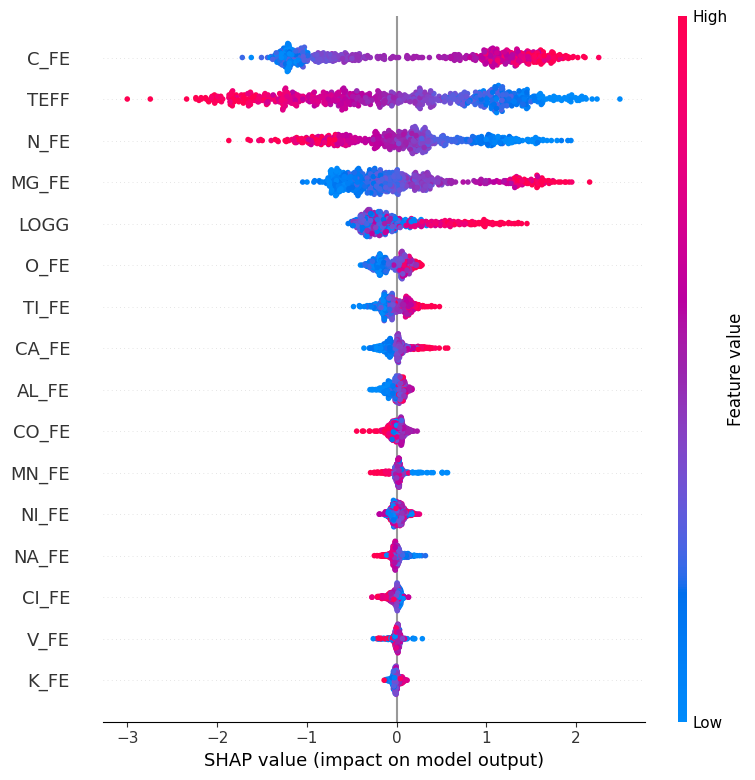

In [39]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
# Same as
#shap.plots.beeswarm(shap_values)
plt.savefig("../im/shap_beeswarm.png", dpi=300)

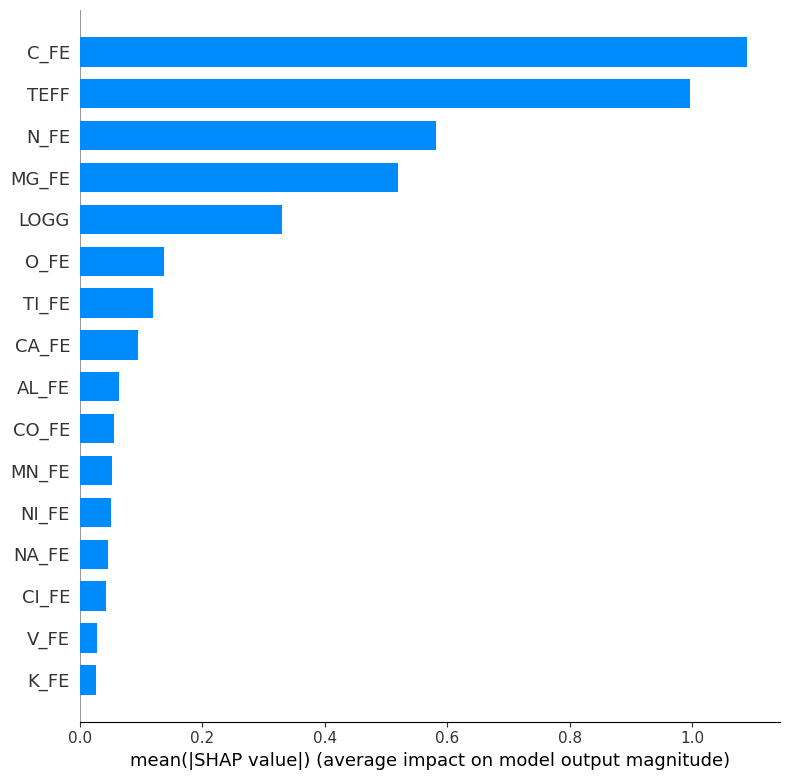

In [40]:
shap.summary_plot(shap_values, test_X, plot_type="bar")

# XGBOOST WITH PERTURBED DATA

# Estimate ages for the APOGEE DR17 data:

We already read the big file above:

In [41]:
big.head()

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


In [44]:
list(big.columns)

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS',
 'MEANFIB',
 'SIGFIB',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'GAIAEDR3_SOURCE_ID',
 'GAIAEDR3_PARALLAX',
 'GAIAEDR3_PARALLAX_ERROR',
 'GAIAEDR3_PMRA',
 'GAIAEDR3_PMRA_ERROR',
 'GAIAEDR3_PMDEC',
 'GAIAEDR3_PMDEC_ERROR',
 'GAIAEDR3_PHOT_G_MEAN_MAG',
 'GAIAEDR3_PHOT_BP_MEAN_MAG',
 'GAIAEDR3_PHOT_RP_MEAN_MAG',
 'GAIAEDR3_DR2_RADIAL_VELOCITY',
 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
 'GAIAEDR3_R_MED_GEO'

Now let's cut out the sample we wish to calculate ages for - and apply the XGBoost model:

In [76]:
features = ['TEFF', 'LOGG', 
            'C_FE',  'CI_FE', 'N_FE', 'O_FE', 
            'NA_FE', 'MG_FE', 'AL_FE', 'K_FE', 
            'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 
            'CO_FE', 'NI_FE']
# For the method to work, we require good measurements for the main features 
#  {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g} etc... (see above for all the criteria)
sel_big = big[selection].dropna(subset=features)
sel_big = sel_big.set_index('APOGEE_ID')

Now filter the necessary columns:

In [60]:
filtered_big = sel_big[features].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

print(len(filtered_big), "stars will be used")

193933 stars will be used


Use the model to infer the age:

In [61]:
pred_big = model.predict(filtered_big)

### Save the results as a table

In [62]:
save_big = filtered_big.copy()
save_big["spec_age_feb2023"] = np.round(pred_big, 2)
save_big = save_big.drop(columns=features)

### Add columns describing the bias and statistical uncertainties 

To do this, we use the comparison with the test sample from above (but now showing the residuals as a function of estimated age):

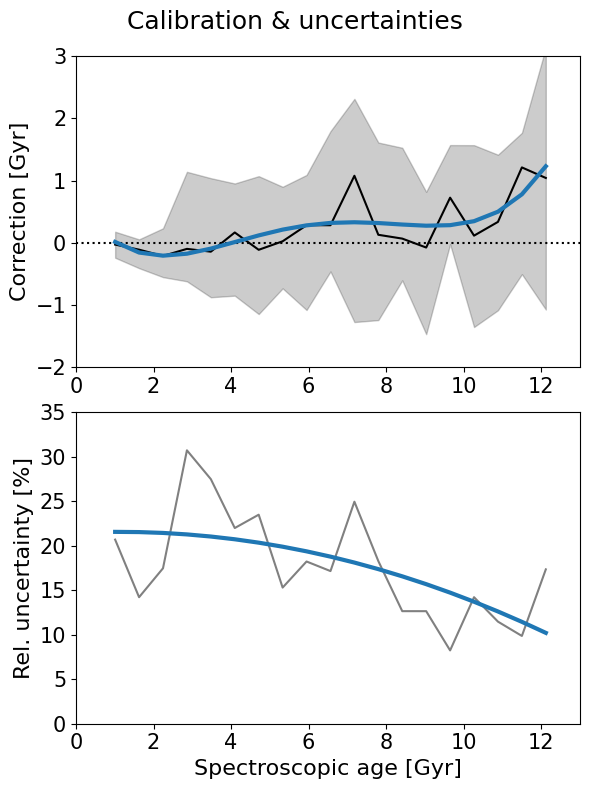

In [92]:
agebins, med, q16, q84 = running_median(pred, test_y-pred, nbins=20)

f, (a0, a1) = plt.subplots(2, 1, height_ratios=[1, 1], figsize=(6,8))

plt.axes(a0)
plt.hlines(0,0,13, color="k", ls="dotted")
plt.axis([0,13,-2,3])
plt.plot(agebins, med, color="k")
plt.fill_between(agebins, q84, q16, alpha=.2, color="k")
med_fit = np.polyfit(agebins, med, 4)
p1 = np.poly1d(med_fit)
plt.plot(agebins, p1(agebins), lw=3)
plt.ylabel(r"Correction [Gyr]", fontsize=16)

plt.axes(a1)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey")
unc_fit = np.polyfit(agebins, uncert, 2)
p2 = np.poly1d(unc_fit)
plt.plot(agebins, p2(agebins), lw=3)
plt.axis([0,13,0,35])
plt.xlabel(r"Spectroscopic age [Gyr]", fontsize=16)
plt.ylabel(r"Rel. uncertainty [%]", fontsize=16)
plt.suptitle(r"Calibration & uncertainties", fontsize=18)
plt.tight_layout()
plt.savefig("../im/estimating_uncertainties.png")

### Define columns containing the calibrated ages and uncertainties - then save this

In [69]:
save_big["spec_age_feb2023_calib"]  = np.round(pred_big + p1(pred_big), 2)
save_big["spec_age_feb2023_uncert"] = np.round(0.01 * p2(pred_big) * pred_big, 2)
save_big.to_csv("../data/spec_ages_feb2023.csv")

### Have a look at the big table

In [78]:
sel_big["spec_age_feb2023"]        = np.array(save_big["spec_age_feb2023"])
sel_big["spec_age_feb2023_calib"]  = np.array(save_big["spec_age_feb2023_calib"])
sel_big["spec_age_feb2023_uncert"] = np.array(save_big["spec_age_feb2023_uncert"])

In [79]:
sel_big

,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,...,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,spec_age_feb2023,spec_age_feb2023_calib,spec_age_feb2023_uncert
APOGEE_ID,,,,,,,,,,,,,,,,,,,,,
b'2M00000133+5721163',b'apo25m',b'NGC7789_btx',b'none',0.005558,57.354549,116.014776,-4.824917,13.261,0.029,12.605,...,NaN,0.025131,2,-0.256490,-0.200830,0.132389,0,4.19,4.21,0.87
b'2M00000211+6327470',b'apo25m',b'117+01',b'none',0.008802,63.463078,117.227985,1.162167,11.880,0.024,11.107,...,NaN,NaN,259,0.194041,0.249701,0.070006,0,3.98,3.97,0.83
b'2M00000222+5625359',b'apo25m',b'N7789',b'none',0.009287,56.426662,115.831519,-5.734687,11.982,0.023,11.433,...,NaN,0.007840,2,-0.356350,-0.300690,0.131302,0,4.16,4.19,0.86
b'2M00000446+5854329',b'apo25m',b'116-04',b'none',0.018603,58.909149,116.330761,-3.302585,12.255,0.023,11.489,...,NaN,NaN,259,0.208779,0.264439,0.087975,0,4.08,4.09,0.85
b'2M00000506+5656353',b'apo25m',b'NGC7789_MGA',b'none',0.021113,56.943142,115.941040,-5.229802,9.317,0.026,8.717,...,NaN,0.009407,2,0.030740,0.086400,0.083735,0,4.02,4.02,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'2M23595553+6339020',b'apo25m',b'117+01',b'none',359.981416,63.650566,117.253198,1.348353,12.551,0.027,11.857,...,NaN,NaN,259,0.247312,0.302972,0.139169,0,1.06,1.06,0.23
b'2M23595669+6131251',b'apo25m',b'116+00',b'none',359.986225,61.523659,116.833497,-0.736743,11.698,0.026,11.048,...,NaN,0.014083,2,-0.017480,0.038180,0.112270,0,2.83,2.65,0.60
b'2M23595837+5700444',b'apo25m',b'N7789',b'none',359.993224,57.012356,115.939899,-5.158948,12.657,0.026,11.992,...,NaN,0.016774,2,-0.035640,0.020020,0.141408,0,4.07,4.08,0.84


In [95]:
print("Median age uncertainty:", np.median(sel_big["spec_age_feb2023_uncert"]), "Gyr")
print("Median relative age uncertainty:", np.round(100.*np.median(sel_big["spec_age_feb2023_uncert"] / sel_big["spec_age_feb2023_calib"]),1), "%")


Median age uncertainty: 1.17 Gyr
Median relative age uncertainty: 18.3 %


## Use internal cross-match to get rid of duplicates and estimate internal uncertainties